In [19]:

import numpy as np

import torch
import matplotlib.pyplot as plt

# import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models

from tqdm import tqdm
!pip install torchmetrics
import torchmetrics
from torchvision.ops import batched_nms

from torch.optim import Adam
from tqdm.notebook import tqdm
from IPython.display import clear_output
from PIL import Image
import numpy as np
import os

In [14]:
NUM_WORKERS = os.cpu_count()

In [5]:
from coco_dataset import CocoDataset

%load_ext autoreload
%autoreload 2

dataset = CocoDataset('datasets\project-2-at-2024-06-25-00-12-031c6fd0', None, False)

image, target = dataset[691]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


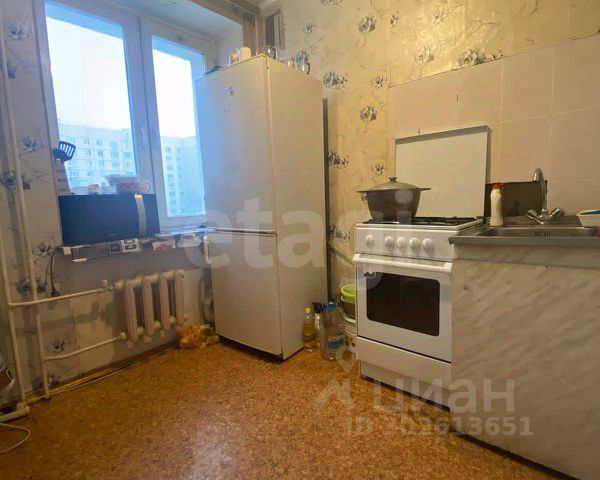

In [60]:
Image.fromarray(image, 'RGB')

In [61]:
target

{'boxes': tensor([[317.0370, 298.0741, 352.0000, 363.8518],
         [299.8518, 302.2222, 320.0000, 356.7408]]),
 'labels': tensor([1, 1])}

In [62]:
dataset.target_names()

[{'id': 0, 'name': 'bag'},
 {'id': 1, 'name': 'bottle'},
 {'id': 2, 'name': 'wall-crack'}]

In [27]:
target_names = dataset.target_names()

targetToIdx = { v['name']: v['id'] for v in target_names }
idxToTarget = { v['id']: v['name'] for v in target_names }

In [64]:
targetToIdx

{'bag': 0, 'bottle': 1, 'wall-crack': 2}

In [65]:
idxToTarget

{0: 'bag', 1: 'bottle', 2: 'wall-crack'}

In [66]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as T
import matplotlib.pyplot as plt

def show(imgs):
    to_pil = T.ToPILImage()

    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 8))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def draw_boxes_single_image(image, boxes, labels):
    colors = ["red" for _ in boxes]

    show(draw_bounding_boxes(image, boxes, labels, colors=colors, width=5))

In [67]:
image, target = dataset.__getitem__(692)

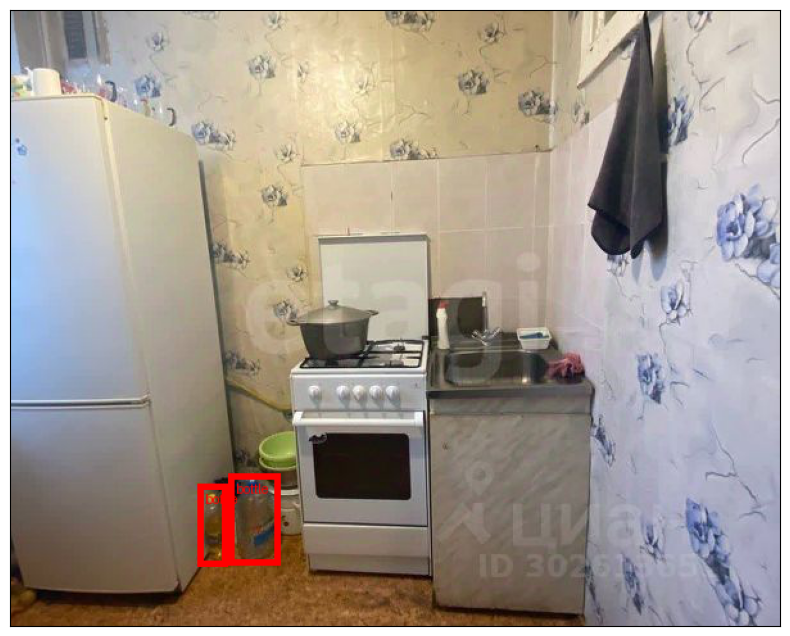

In [68]:
image, target = dataset.__getitem__(692)
draw_boxes_single_image(
    T.PILToTensor()(Image.fromarray(image, 'RGB')),
    target['boxes'],
    [idxToTarget[label.item()] for label in target['labels']]
)

In [10]:
def split_data(dataset, val_size=0.2, seed=42):
    generator = torch.Generator().manual_seed(seed)
    train_data, test_data = random_split(dataset, [1 - val_size, val_size], generator=generator)

    return train_data, test_data

In [16]:
def create_dataloaders(
    data_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    dataset = CocoDataset(data_dir, transform)
    
    train_set, test_set = split_data(dataset)

    class_names =  dataset.target_names

    train_dataloader = DataLoader(
        train_set,                # dataset from which to load the data
        batch_size=batch_size,    # how many samples per batch to load
        shuffle=True,             # set to True to have the data reshuffled at every epoch
        num_workers=num_workers,  # how many subprocesses to use for data loading
        pin_memory=True,          # If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
    )
    test_dataloader = DataLoader(
        test_set,                 # dataset from which to load the data
        batch_size=batch_size,    # how many samples per batch to load
        shuffle=False,            # set to True to have the data reshuffled at every epoch
        num_workers=num_workers,  # how many subprocesses to use for data loading
        pin_memory=True,          # If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
    )

    return train_dataloader, test_dataloader, class_names

In [17]:
# TODO: применить transforms
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) 
])

In [18]:
train_loader, test_loader, class_names = create_dataloaders(
        data_dir='datasets\project-2-at-2024-06-25-00-12-031c6fd0',
        transform=manual_transforms,
        batch_size=32
    )

In [25]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_detection_model():
    model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

    model.roi_heads.box_predictor = FastRCNNPredictor(1024, len(target_names))

    return model

In [20]:

def train(model):
    model.train()
    
    optimizer = Adam([p for p in model.parameters() if p.requires_grad], lr=1e-4)
    
    for x, y in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()
        
        output = model(x, y)
        
        loss_sum = sum(loss for loss in output.values())
        
        loss_sum.backward()
        
        optimizer.step()

In [21]:
def apply_nms(orig_prediction, iou_thresh=0.3):

    keep = batched_nms(orig_prediction['boxes'], orig_prediction['scores'], orig_prediction['labels'], iou_thresh)

    final_prediction = orig_prediction

    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

In [22]:
@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    to_pil = T.ToPILImage()
    to_tensor = T.PILToTensor()

    xs, ys = batch

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = {k: v for k, v in model([x])[0].items()}

        prediction = apply_nms(prediction)

        x = to_tensor(to_pil(x.cpu()))

        true_boxes = draw_bounding_boxes(x, boxes=y['boxes'], labels=[idxToTarget[label.item()] for label in y['labels']], width=5, colors='red')
        predicted_boxes = draw_bounding_boxes(x, boxes=prediction['boxes'], labels=[idxToTarget[label.item()] for label in prediction['labels']], width=5, colors='red')

        fig, ax = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')

        ax[0].imshow(to_pil(true_boxes))
        ax[1].imshow(to_pil(predicted_boxes))

        ax[0].axis('off')
        ax[1].axis('off')

        ax[0].set_title('Target boxes')
        ax[1].set_title('Predicted boxes')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [23]:
def whole_train_valid_cycle(model, num_epochs, title):
    batch = next(iter(test_loader))

    for epoch in range(num_epochs):
        train(model)

        clear_output()

        visualize(model, batch)

In [28]:
model = get_detection_model()

In [29]:
whole_train_valid_cycle(model, 15, 'Faster R-CNN finetune')

PicklingError: Can't pickle <class 'coco_dataset.CocoDataset'>: it's not the same object as coco_dataset.CocoDataset